## Reduced basis method

Author: Julian Lißner

For questions and feedback write a mail to: [lissner@mib.uni-stuttgart.de](mailto:lissner@mib.uni-stuttgart.de)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from numpy.fft import fft2, ifft2
from scipy.special import binom, gamma
from scipy.interpolate import interp1d

## The curse of dimensionality

- volume and surface of a hypercube/hypersphere are given as follows
- source of equations: [wolfram](https://mathworld.wolfram.com/Hypersphere.html)/[wikipedia](https://en.wikipedia.org/wiki/N-sphere)

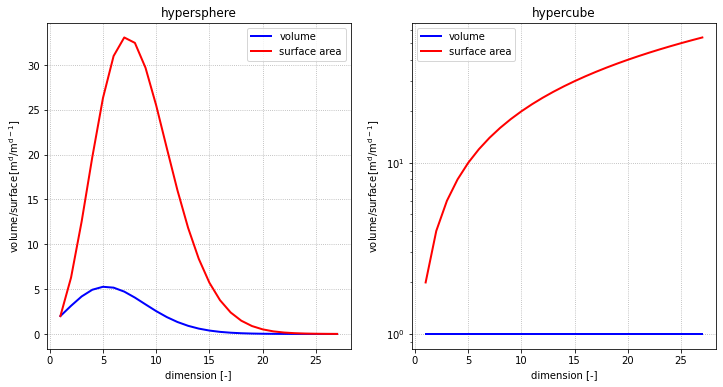

In [2]:
def hypersphere_properties( dimension, radius=1, computation='recursive'):
    """
    computes the volume of an hyperball with <radius>
    up to the highest number in 'dimension'
    Parameters:
    -----------
    dimension:      integer
                    up to which dimension to compute
    radius:         float
                    sidelength of the hypersphere
    computation:    string, default 'recursive'
                    type of computation, choose between 'recursive'
                    or 'closed form'
    Returns:
    --------
    volume:         numpy array
                    volume of the nball up to dimension <integer>
    surface:        numpy array
                    surface area of the nball up to dimension <integer>
    """
    if computation == 'recursive':
        volume = [2*radius, pi* radius**2] #1,2d
        surface = [2, 2*pi]
        for i in range( 2, dimension):
            surface.append( 2* pi* volume[-2])
            volume.append( 2* pi* radius**2/ (i+1) * volume[-2] )
    else:
        d = np.arange( dimension) + 1
        G = gamma( 1+ d/2)  #gamma function
        volume = pi**(d/2)*radius**d/G
        surface = pi**(d/2) *d* radius**(d-1)/G
    return np.array( volume), np.array( surface)

def hypercube_properties( dimension, sidelength=1):
    """
    computes the volume of an hypercube with sidelengths 1
    up to the highest number in 'dimension'
    Parameters:
    -----------
    dimension:      integer
                    up to which dimension to compute
    sidenlength:    float
                    sidelength of the hypercube
    Returns:
    --------
    volume:         numpy array
                    volume of the hypercube up to dimension <integer>
    surface:        numpy array
                    surface area of the hypercube up to dimension <integer>
    """
    surface = lambda d: 2*d*sidelength**(d-1)
    d = np.arange(  dimension ) +1
    volume = sidelength**d
    return volume, surface(d)

dimensions = np.arange( 1, 28)
hypersphere = hypersphere_properties( dimensions[-1] )
hypercube = hypercube_properties( dimensions[-1] )

colors = ['blue', 'red']
labels = ['volume', 'surface area']
fig, axes = plt.subplots( 1, 2, figsize=(12,6) )
for i in range( 2):
    axes[0].plot( dimensions, hypersphere[i], color=colors[i], linewidth=2, label=labels[i] )
    axes[1].semilogy( dimensions, hypercube[i], color=colors[i], linewidth=2, label=labels[i] )

titles = ['hypersphere', 'hypercube' ]
for ax in axes:
    ax.legend()
    ax.set_title( titles.pop(0) )
    ax.grid( ls=':', color='#AAAAAA')
    ax.set_xlabel( 'dimension [-]')
    ax.set_ylabel( r'$\rm{volume/surface}\, [\rm{m}^d/\rm{m}^{d-1}]$')

- volume and surface of hypersphere tend to 0, even though radius is constant at 1 (!)
- the distance of two points in a hypersphere is at most $2r$ in any dimension
- volume of hypercube is defined as: $V = a^d$
- surface area of the hyptercube is defined as: $S = 2d \cdot a^d$
- for a unitary hypercube ($a=1$), the volume is constant while surface area grows continuously<br>


- samples of $d$ values on the interval [0,1] are sampled from the $d$-hypercube
- the distance $l$ between two samples in $d$ dimensional space is defined as
$$ l = \sqrt{ \sum\limits_{i=1}^{d} (s^{(1)}_i - s^{(2)}_i )^2 } $$
- the more dimensions, the higher the average distance of two points in a hypercube

In [3]:
d_dimensional_distance = lambda s_1, s_2: np.sum( (s_1-s_2)**2 )
    
n_samples = 25
dimensions = [2, 3, 10, 20]

for dimension in dimensions:
    distance = np.sqrt( dimension)
    for i in range( n_samples):
        sample_1 = np.random.rand( dimension )
        sample_2 = np.random.rand( dimension )
        distance = min( d_dimensional_distance( sample_1, sample_2), distance) 
    print( 'minimum distance between {} samples in {:2.0f} dimensional hypercube: {:.6f}'.format( n_samples, dimension, distance  ) ) 

minimum distance between 25 samples in  2 dimensional hypercube: 0.014761
minimum distance between 25 samples in  3 dimensional hypercube: 0.015848
minimum distance between 25 samples in 10 dimensional hypercube: 0.523474
minimum distance between 25 samples in 20 dimensional hypercube: 1.734135


- higher distance between samples in higher dimensional space $\blacktriangleright$ _curse of dimensionality_
- machine learning generally interpolates between known data points
- if the data is too distant, a good model is difficult to built

---------------------
----------

## Snapshot POD
__NOTE:__ data is aranged column wise, each column one sample
- constructs a Reduced Basis (RB) with the given data $\underline{\underline{ S}} \in \mathbb R^{n\times n_s}$
- RB eigenmodes sorted in descending order, first is most _important_
- eigenmodes capture the highest variance in the data, first eigenmode captures most variance <br>
$\quad \blacktriangleright$ retain the most information in the data in the fewest eigenmodes 
- illustration on 2d<br>
__NOTE__: generally $n_s \ll n$, to visualize the effect in 2d this rule has been violated

shape of my snapshot data (2, 300)
number of eigenmodes in B: 2
column orthogonality of B: B.T @ B =
 [[ 1. -0.]
 [-0.  1.]]
is reprojection lossless? True
(3, 2)


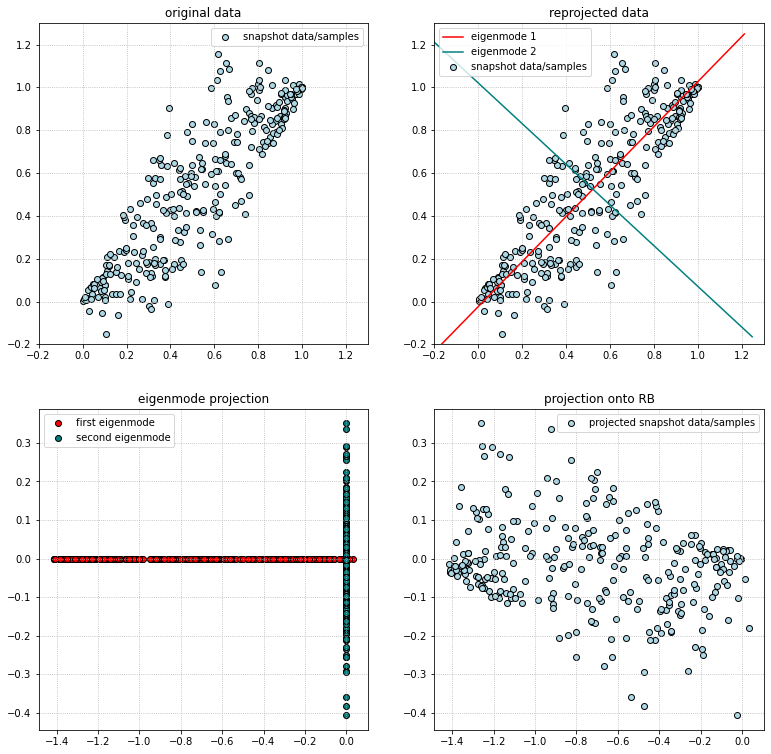

In [4]:
## Data generation
n_samples = 300
x = np.random.rand( n_samples)
noise = x*(1-x) * np.random.randn( n_samples)
y = x + noise
S = np.vstack( (x,y) )
print( 'shape of my snapshot data', S.shape)

B = np.linalg.svd( S, full_matrices=False)[0] 
reduced_coefficients = B.T @ S
reprojection = B @ ( B.T @ S) # = B @ reduced_coefficients

print( 'number of eigenmodes in B:', B.shape[1])
print( 'column orthogonality of B: B.T @ B =\n', np.around(B.T @ B, 6) )
print( 'is reprojection lossless?', np.allclose( S, reprojection) )

#plotting allocations
data_center = S.mean(1)
eigenmode_1 = np.vstack( (data_center-B[:,0], data_center, data_center+B[:,0]) )
eigenmode_2 = np.vstack( (data_center-B[:,1], data_center, data_center+B[:,1]) )
print( eigenmode_2.shape)

fig, axes = plt.subplots( 2,2, figsize=(13,13) )
axes = axes.flatten()
axes[0].scatter(  S[0], S[1], facecolor='lightblue', edgecolor='k', label='snapshot data/samples' )
axes[1].scatter(  reprojection[0], reprojection[1], facecolor='lightblue', edgecolor='k', label='snapshot data/samples' )
axes[1].plot( eigenmode_1[:,0], eigenmode_1[:,1], color='red', label='eigenmode 1')
axes[1].plot( eigenmode_2[:,0], eigenmode_2[:,1], color='teal', label='eigenmode 2')
axes[2].scatter(  reduced_coefficients[0], np.zeros( n_samples), facecolor='red', edgecolor='k', label='first eigenmode' )
axes[2].scatter(  np.zeros( n_samples), reduced_coefficients[1], facecolor='teal', edgecolor='k', label='second eigenmode' )
axes[3].scatter(  reduced_coefficients[0], reduced_coefficients[1], facecolor='lightblue', edgecolor='k', label='projected snapshot data/samples' )

titles = [ 'original data', 'reprojected data', 'eigenmode projection', 'projection onto RB']
axes[2].legend()
axes[0].set_xlim( -.2, 1.3)
axes[0].set_ylim( -.2, 1.3)
axes[1].set_xlim( axes[0].get_xlim())
axes[1].set_ylim( axes[0].get_ylim())
for ax in axes:
    ax.grid( ls=':')
    ax.set_title( titles.pop(0))
    ax.legend()

- only two eigenmodes, more modesl would be linearly dependent
- here: $\underline{\underline B}$ describes a rotation/mirroring, otherwise a projection onto lower dimensional space
- $\underline{\underline B}^T\, \underline{\underline B} \, \underline{\underline S} \approx \underline{\underline S}$, which is exact in this case
- reprojection generally yields a loss of information, otherwise no dimension reduction would be given

### Application on image data
- theory already introduced, only data changes
- capture largest variation in data in the leading eigenmodes
- truncated eigenmodes $\blacktriangleright$ loss of information

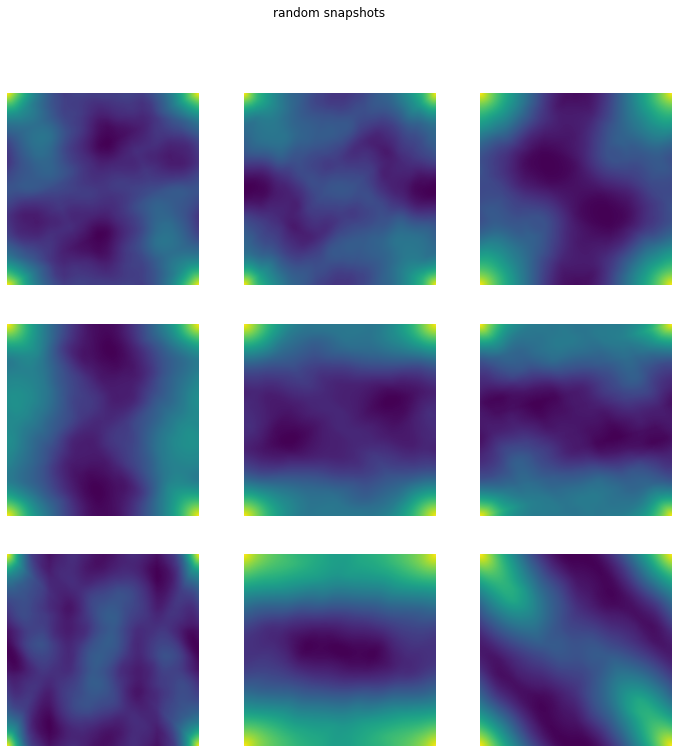

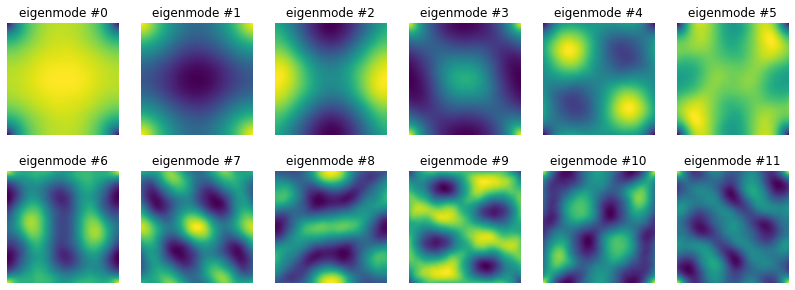

In [5]:
images = np.load( 'data/rb_image_data.npz' )['arr_0'] 
n_snapshots = images.shape[1]
pcf = lambda image: ifft2( fft2( image)* np.conj( fft2(image)) ).real /np.prod(image.shape)
S = np.zeros( images.shape)
for i in range( n_snapshots ):
    S[:,i] = pcf( images[:,i].reshape( 400,400 ) ).flatten()
B, sigma, WT = np.linalg.svd( S, full_matrices=False )


fig, axes = plt.subplots( 3,3, figsize=(12,12))
axes = axes.flatten()
for i in range( len( axes )):
    axes[i].imshow( S[:,np.random.randint( 0, n_snapshots) ].reshape( 400, 400) )
    axes[i].axis( 'off' )
fig.suptitle( 'random snapshots' )

title = 'eigenmode #{}'
fig, axes = plt.subplots( 2, 6, figsize=(14, 5) )
axes = axes.flatten()
for i in range( len( axes) ):
    axes[i].imshow( B[:, i].reshape( 400, 400 ) )
    axes[i].axis( 'off' )
    axes[i].set_title( title.format(i) )

- $\sigma_i \blacktriangleright$ _significance_ of eigenmode $i$
- $\sigma$ gives insight into mean projection error
- no guarantee of maximum projection error
- generally only few eigenmodes suffice for a good representation of the data in $B$

projection error of a single sample: 0.008645212556902792


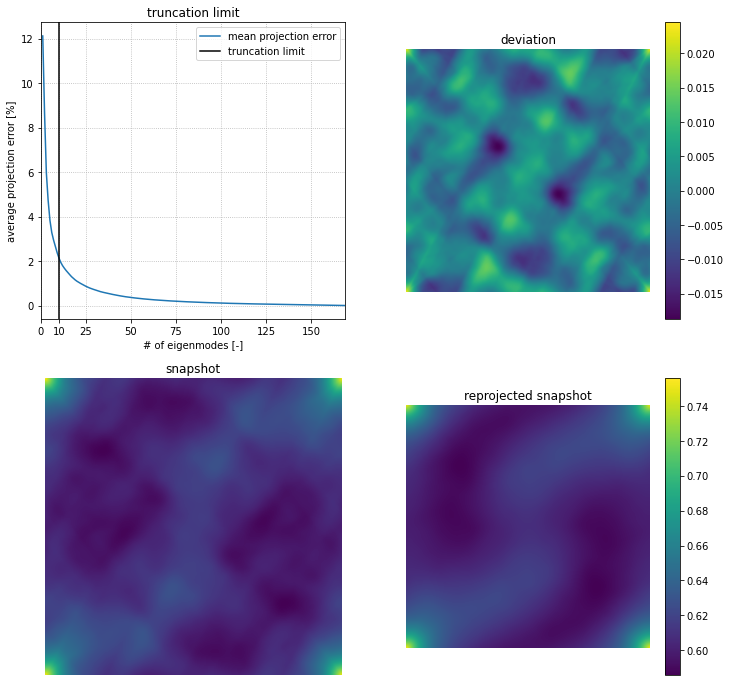

In [6]:
error = np.sqrt( np.maximum( 1- np.cumsum( sigma**2) /np.sum( sigma**2) ,0  ) )
threshold = 0.02
N = np.argwhere( error <= threshold).flatten()[0] #first occurence where it is under threshold
B_truncated = B[:,:N]
i = np.random.randint( 0, n_snapshots)
S_reprojected = B_truncated @ (B_truncated.T @S[:,i] ) 
deviation = S[:,i].reshape(400,400 ) - S_reprojected.reshape( 400, 400) 

fig, axes = plt.subplots( 2, 2, figsize=(12,12))
axes = axes.flatten()
axes[0].plot( np.arange( n_snapshots) +1, 100*error, label='mean projection error' )
axes[0].axvline( N, color='k', label='truncation limit' ) 
axes[2].imshow( S[:,i].reshape(400,400 ) )
deviation_plot = axes[1].imshow( deviation)
reprojection_plot = axes[3].imshow( S_reprojected.reshape( 400, 400) )

titles = ['truncation limit', 'deviation', 'snapshot', 'reprojected snapshot' ]
plt.colorbar( deviation_plot, ax=axes[1] )
plt.colorbar( reprojection_plot, ax=axes[3] )
axes[0].grid( ls=':' )
axes[0].legend()
axes[0].set_ylabel( 'average projection error [%]' )
axes[0].set_xlabel( '# of eigenmodes [-]' )
axes[0].set_xticks( list(axes[0].get_xticks()) + [N] )
axes[0].set_xlim( xmin=0, xmax=B.shape[1])
axes[0].set_title( titles.pop(0) )
for ax in axes[1:]:
    ax.axis('off')          
    ax.set_title( titles.pop(0))
print( 'projection error of a single sample:', np.linalg.norm( deviation, 'fro')/np.linalg.norm( S[:,i].reshape(400,400), 'fro' ) )